In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
from torchvision.io import read_image

import matplotlib.pyplot as plt
from torchvision import models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [2]:
!mkdir /root/.config/kaggle/
!mv kaggle.json /root/.config/kaggle/

In [3]:
!kaggle datasets download vipoooool/new-plant-diseases-dataset

Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
100% 2.70G/2.70G [00:31<00:00, 120MB/s] 
100% 2.70G/2.70G [00:31<00:00, 92.4MB/s]


In [4]:
!unzip new-plant-diseases-dataset.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665_270deg.JPG  
  inflating: new plant diseases datase

In [5]:
import os
from torchvision import datasets, transforms

dataset_path = "New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"

train_dir = os.path.join(dataset_path, 'train')
valid_dir = os.path.join(dataset_path, 'valid')

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(valid_dir, transform=val_transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Training classes: {train_dataset.classes}")
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")

Training classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', '

In [47]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

random_state = 42

train_labels = [label for _, label in train_dataset.samples]
train_indices = list(range(len(train_dataset)))

val_labels = [label for _, label in val_dataset.samples]
val_indices = list(range(len(val_dataset)))

small_train_idx, _ = train_test_split(
        train_indices,
        train_size=batch_size * 10,
        stratify=train_labels,
        random_state=random_state
)

small_val_idx, extra_idx = train_test_split(
        val_indices,
        train_size=batch_size * 10,
        stratify=val_labels,
        random_state=random_state
)

small_train = Subset(train_dataset, small_train_idx)
small_val = Subset(val_dataset, small_val_idx)
small_test = Subset(val_dataset, np.random.choice(extra_idx, batch_size * 5, replace=False))

small_train_loader = DataLoader(small_train, batch_size=batch_size, shuffle=True)
small_val_loader = DataLoader(small_val, batch_size=batch_size, shuffle=False)
small_test_loader = DataLoader(small_test, batch_size=batch_size, shuffle=False)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

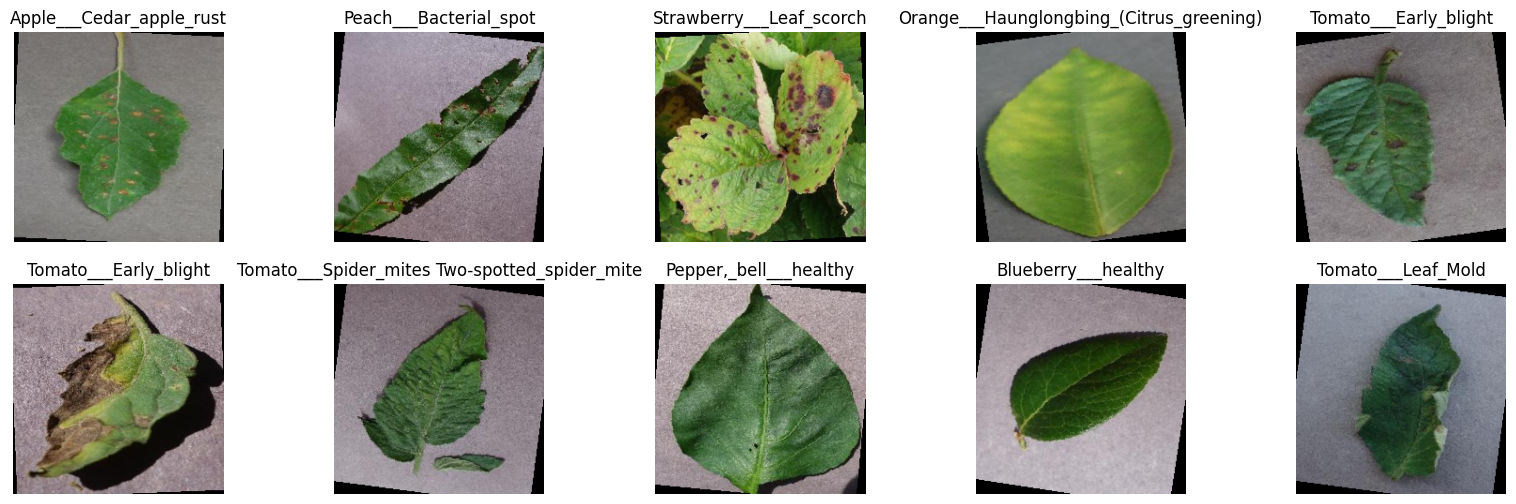

In [46]:
def plot_images(images, labels, classes, rows=2, columns=5):
    """
    Plots images with captions

    :param images: list of images to plot
    :param captions: captions of images:
    :param rows: number of rows in figure
    :param columns: number of columns:
    :param title: super title of figure
    """
    fig = plt.figure(figsize=(20, 6))
    for i, img in enumerate(images):
        img = img.numpy().transpose((1, 2, 0))
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(img)
        if i < len(labels):
            plt.title(classes[labels[i]])
        plt.axis("off")
    plt.show()


images, labels = next(iter(small_train_loader))
plot_images(images[:10], labels, train_dataset.classes)

In [52]:
model = models.efficientnet_b3(pretrained=True)

num_classes = len(train_dataset.classes)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [53]:
from tqdm.notebook import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        model.train()
        running_loss = 0.0
        running_corrects = 0

        for data in tqdm(train_loader, desc='Training'):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        total_number = len(train_loader.dataset)
        epoch_loss = running_loss / total_number
        epoch_acc = running_corrects.item() / total_number
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for data in tqdm(val_loader, desc='Validation'):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        total_number = len(val_loader.dataset)
        val_epoch_loss = val_loss / total_number
        val_epoch_acc = val_corrects.item() / total_number
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc)

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')

        if val_epoch_acc > best_acc:
            best_acc = val_epoch_acc
            torch.save(model.state_dict(), 'best_rexnet_model.pth')

        scheduler.step()
        print()

    return history, model

In [54]:
history, trained_model = train_model(
    model, small_train_loader, small_val_loader, criterion, optimizer, scheduler, num_epochs=10
)

Epoch 1/10
----------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 3.4929 Acc: 0.1531
Val Loss: 3.1568 Acc: 0.4531

Epoch 2/10
----------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 2.1949 Acc: 0.7188
Val Loss: 1.6118 Acc: 0.6438

Epoch 3/10
----------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.8350 Acc: 0.8656
Val Loss: 0.7874 Acc: 0.7781

Epoch 4/10
----------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.2657 Acc: 0.9469
Val Loss: 0.7676 Acc: 0.7906

Epoch 5/10
----------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.1360 Acc: 0.9781
Val Loss: 0.8109 Acc: 0.7500

Epoch 6/10
----------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.0736 Acc: 0.9812
Val Loss: 0.6980 Acc: 0.7812

Epoch 7/10
----------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.0711 Acc: 0.9906
Val Loss: 0.6657 Acc: 0.7969

Epoch 8/10
----------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.0481 Acc: 0.9875
Val Loss: 0.5928 Acc: 0.8375

Epoch 9/10
----------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.0430 Acc: 0.9906
Val Loss: 0.5663 Acc: 0.8375

Epoch 10/10
----------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.0223 Acc: 0.9969
Val Loss: 0.5290 Acc: 0.8375



In [55]:
test_loss_accum = 0.0
test_corrects_accum = 0

model.eval()

with torch.no_grad():
  for data in tqdm(small_test_loader, desc='Test'):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, 1)

      test_loss_accum += loss.item() * inputs.size(0)
      test_corrects_accum += torch.sum(preds == labels.data)

total_number = len(small_test_loader.dataset)
test_loss = test_loss_accum / total_number
test_acc = test_corrects_accum / total_number

print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
print(f'{test_corrects_accum} / {total_number}')

Test:   0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 0.6267 Acc: 0.8313
133 / 160


In [57]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def generate_classification_report(model, test_loader, class_names, device):
    """
    Generate comprehensive classification report
    """
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            _, predictions = torch.max(outputs, 1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_probabilities = np.array(all_probabilities)

    report = classification_report(all_labels, all_predictions,
                                 target_names=class_names, output_dict=True)

    return report, all_predictions, all_labels, all_probabilities

class_names = val_dataset.classes # we gathered small_test_loader from validation dataset

report, predictions, true_labels, probabilities = generate_classification_report(
    model, small_test_loader, class_names, device
)


print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))

Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      0.71      0.83         7
                                 Apple___Black_rot       0.50      1.00      0.67         1
                          Apple___Cedar_apple_rust       1.00      0.50      0.67         2
                                   Apple___healthy       0.00      0.00      0.00         1
                               Blueberry___healthy       1.00      1.00      1.00         7
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00         5
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00         4
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       1.00      0.50      0.67         4
                       Corn_(maize)___Common_rust_       0.80      1.00      0.89         4
               Corn_(maize)___Northern_Leaf_Blight      

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

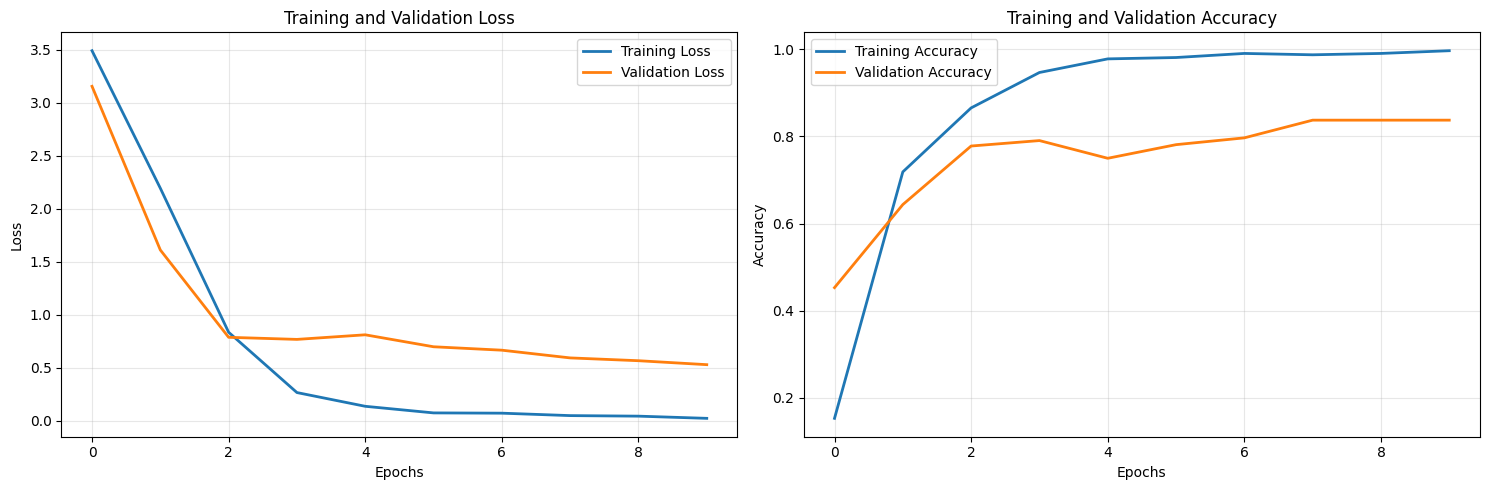

In [56]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plot training and validation loss and accuracy
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    ax1.plot(history['train_loss'], label='Training Loss', linewidth=2)
    ax1.plot(history['val_loss'], label='Validation Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot accuracy
    ax2.plot(history['train_acc'], label='Training Accuracy', linewidth=2)
    ax2.plot(history['val_acc'], label='Validation Accuracy', linewidth=2)
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Usage
plot_training_history(history)

In [44]:
import torch
from PIL import Image
import torch.nn.functional as F

def predict_image(image_path, model, transform, class_names, device):
    """
    Predict class for a single image
    """
    # 1. Open image
    image = Image.open(image_path).convert('RGB')

    # 2. Apply transformations
    input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    input_tensor = input_tensor.to(device)

    # 3. Model prediction
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = F.softmax(outputs, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)

    # 4. Get class name
    predicted_idx = predicted_class.item()
    predicted_name = class_names[predicted_idx]
    confidence_score = confidence.item()

    return predicted_name, confidence_score, predicted_idx

# Usage example
predicted_class, confidence, class_idx = predict_image(
    image_path="/content/test/test/TomatoHealthy1.JPG",
    model=model,
    transform=val_transform,
    class_names=train_dataset.classes,  # or your class names
    device=device
)

print(f"Predicted: {predicted_class} (confidence: {confidence:.4f})")

Predicted: Tomato___healthy (confidence: 0.9642)
